# EVALUATE RESULTS

### Import relevant packages

In [300]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state ("rs1" to "rs10" for the 10 random seeds, plus "al" for active learning and "full" for models trained on all available training data)

In [301]:
results_dict = dict()

for testset in sorted(os.listdir("./results")):
    print(testset)
    results_dict[testset] = dict()

    for model in sorted(pd.unique(["_".join(m.split("_")[:4]) for m in os.listdir(f"./results/{testset}")])):
        if "ipynb" not in model:
            print("  ", model)
            results_dict[testset][model] = dict()

            for size in sorted(pd.unique([int(i.split("_")[-2]) for i in glob.glob(f"./results/{testset}/{model}*.csv")])):
                if size!=0:
                    results_dict[testset][model][size] = dict()
                    for random_state in sorted(pd.unique([i.split("_")[-1].rstrip(".csv") for i in glob.glob(f"./results/{testset}/{model}*_{size}_*.csv")])):
                        for filename in glob.glob(f"./results/{testset}/{model}*{size}_{random_state}.csv"):
                            results_dict[testset][model][size][random_state] = pd.read_csv(filename)

            # 0-shot xlmt models
            #for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
            #    results_dict[testset][model][0] = dict()
            #    results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)
            #    del results_dict[testset][model][20000]["rs1"] # delete redundant entry

bas19_es_test_2000
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
for19_pt_test_2000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
has21_hi_test_2000
   hibert_hi_has21_hi
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_ar
   arabert_ar_ous19_ar
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_es
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_hi
   hibert_hi_has21_hi
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_it
   umberto_it_san20_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xl

### Compute macro F1 for each model/testset combination

In [302]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
for19_pt_test_2000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
has21_hi_test_2000
  hibert_hi_has21_hi
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_ar
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_hi
  hibert_hi_has21_hi
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_it
  umberto_it_san20_it
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
ous19_ar_test_1000
  a

### Create flat df of results for easier plotting

In [303]:
%%time

metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, int(size), selection_strat, metrics_dict[testset][model][size][selection_strat]]

metrics_df["log_train_size"] = metrics_df.train_size.apply(lambda x: np.log(x))
metrics_df["selection_strat_category"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else ("full" if x=="full" else "random"))

CPU times: user 3.01 s, sys: 60.2 ms, total: 3.07 s
Wall time: 3.07 s


### Validate that no results are missing
Expecting 10 results from 10 different random seeds per testset + model + train_size (n = 12) --> 120 per model

In [304]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model", "train_size"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=10]

,testset,model,train_size,selection_strat


In [305]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=120].sort_values("model")

,testset,model,selection_strat


## Summary Plots
### Average macro F1 across random seeds across models for each testset

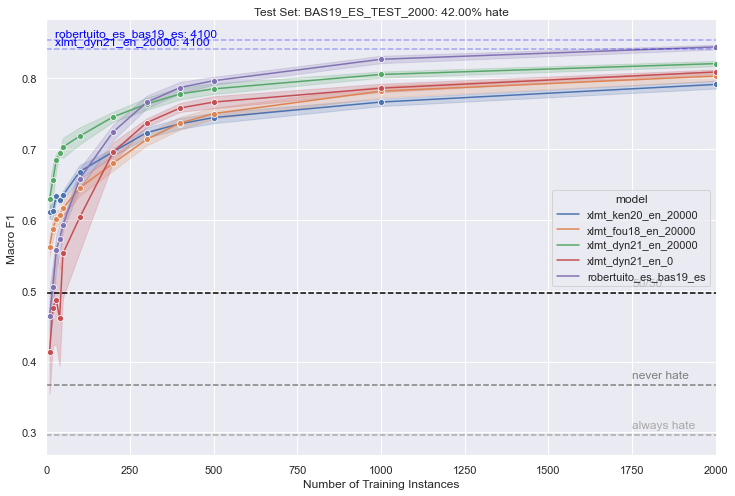

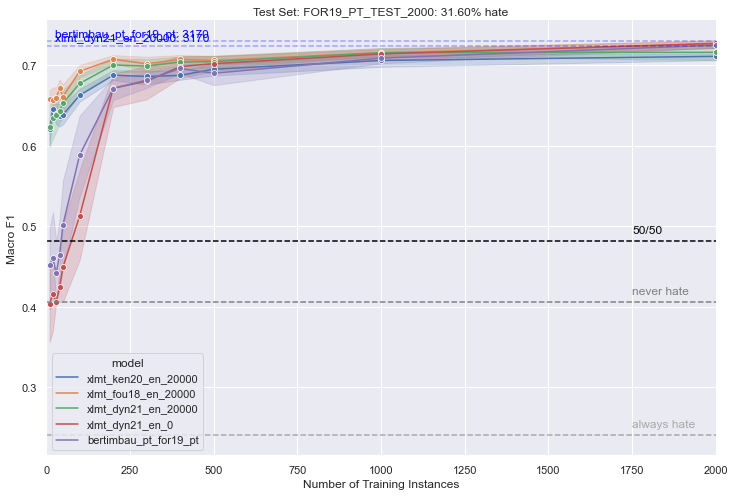

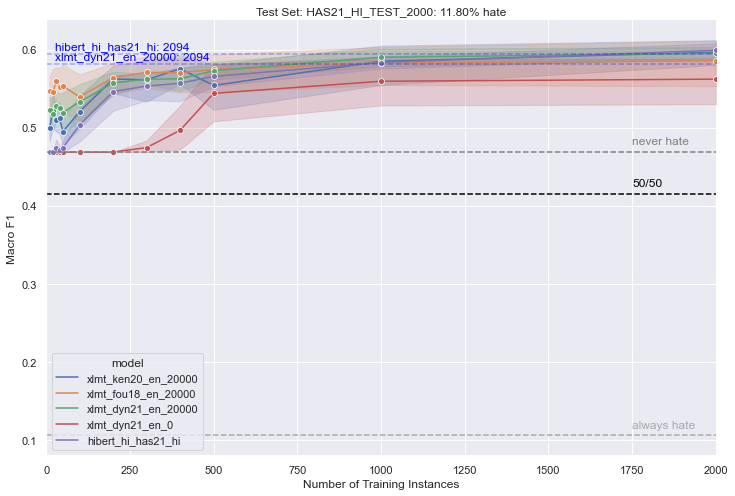

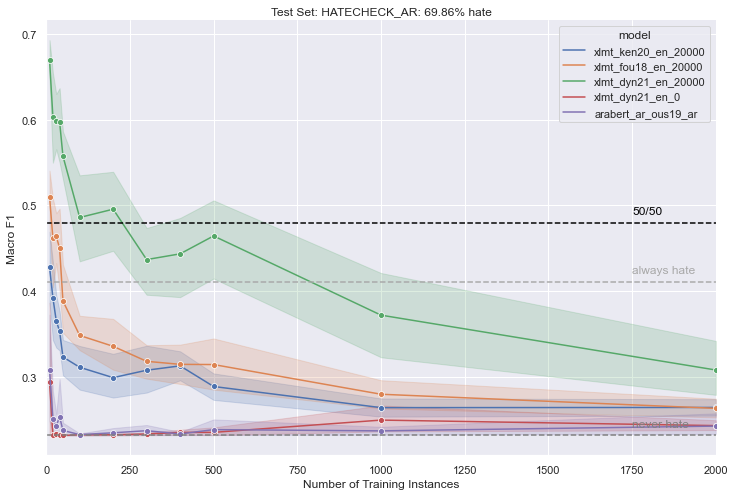

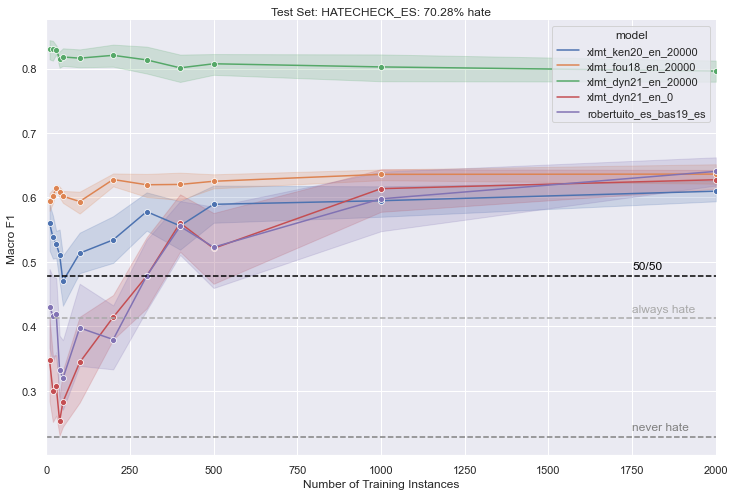

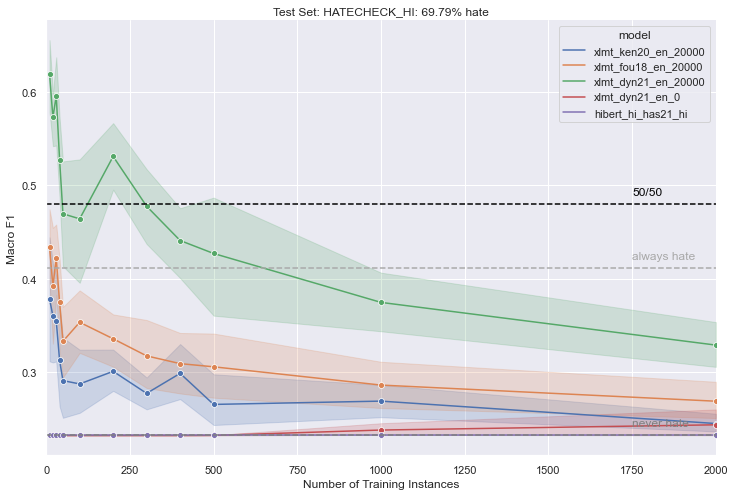

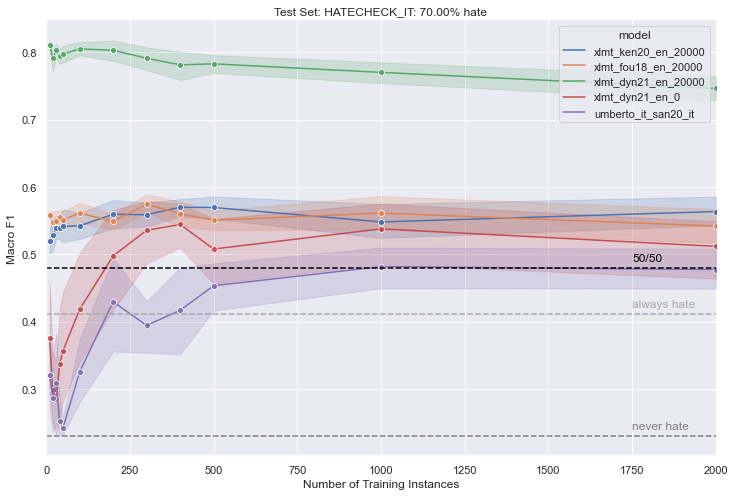

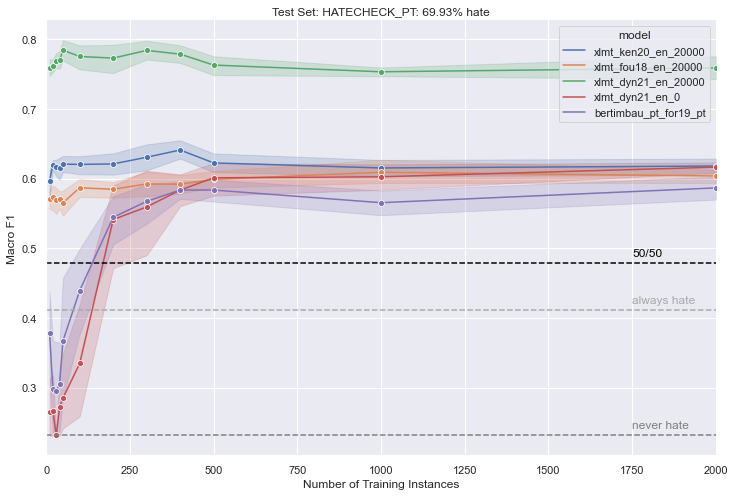

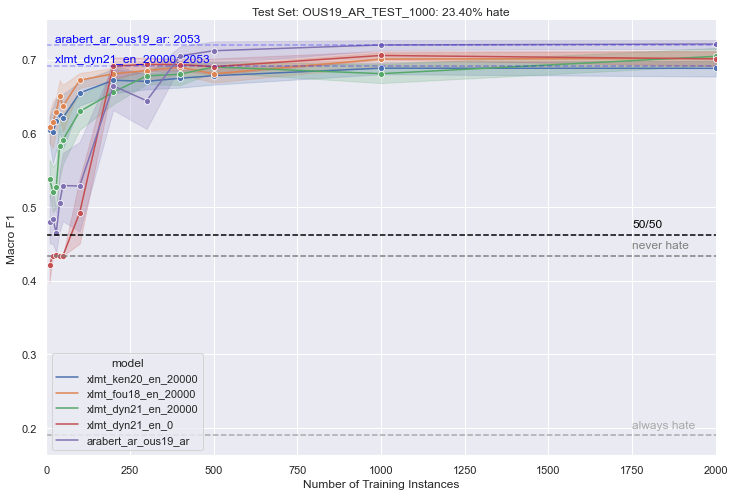

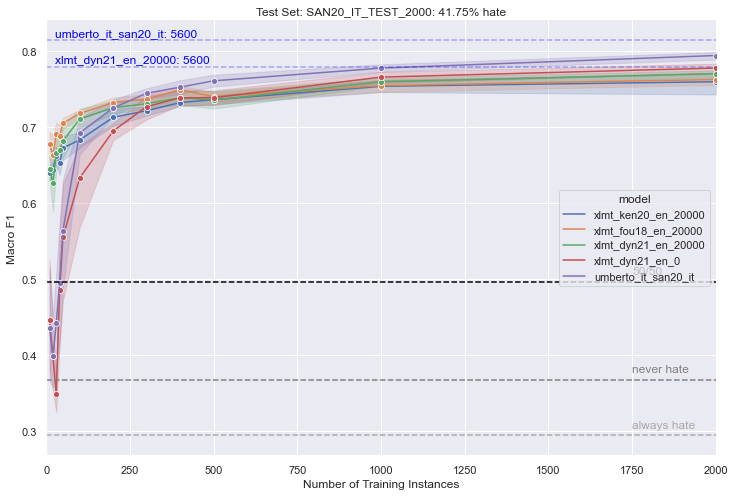

In [306]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

for target_testset in sorted([t for t in metrics_dict.keys()]):

    f = plt.figure(figsize=(12,8))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # Model performance on full data: 
    if RESULTS_ON_FULL_DATA:
        for _, row in metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="full")].sort_values(["model"]).iterrows():
            p.axhline(row.macro_f1, color="blue", linestyle="--", alpha=0.3)
            p.annotate(f"{row.model}: {row.train_size}", xy= (1750,row.macro_f1),  xytext=(25,row.macro_f1+0.005), color = "blue")
    
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        p.axhline(always_hate, color="darkgrey", linestyle="--")
        p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        p.axhline(never_hate, color="grey", linestyle="--")
        p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        p.axhline(equal_prob, color="black", linestyle="--")
        p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.01), color="black")
    
    # Plot formatting
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()

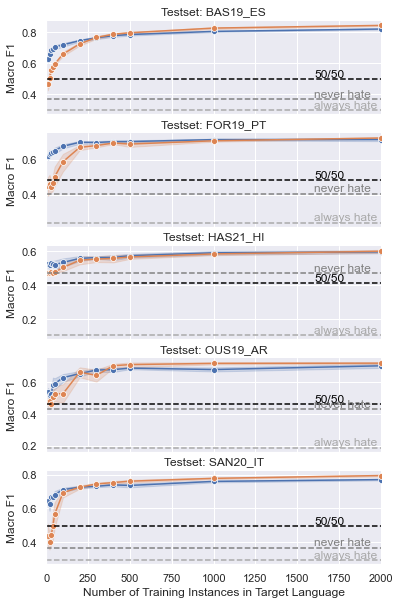

In [307]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(6,10))

for target_testset, ax in zip(sorted([t for t in metrics_dict.keys() if "hatecheck" not in t]), axes):
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    
    # Filter out models that we don't want to show
    plot_df = plot_df[(~plot_df.model.str.contains("ken"))&(~plot_df.model.str.contains("fou"))&(~plot_df.model.str.contains("_0"))]
    
    ax = sns.lineplot(ax=ax, x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        ax.axhline(always_hate, color="darkgrey", linestyle="--")
        ax.annotate('always hate', xy= (1600,always_hate),  xytext=(1600,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        ax.axhline(never_hate, color="grey", linestyle="--")
        ax.annotate('never hate', xy= (1600,never_hate),  xytext=(1600,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        ax.axhline(equal_prob, color="black", linestyle="--")
        ax.annotate('50/50', xy= (1600,equal_prob),  xytext=(1600,equal_prob+0.01), color="black")
    
    # Plot formatting
    ax.set_title(f"Testset: {target_testset.upper()[:-10]}")
    ax.set_xlabel("Number of Training Instances in Target Language")
    ax.set_ylabel("Macro F1")
    ax.set_xlim(0,2000)
    ax.get_legend().remove()
    sns.despine()
    #plt.show()

In [ ]:
# load hatecheck cases

hatecheck_dict = dict()

for hc in sorted(os.listdir("../0_data/hatecheck/")):
    if "ipynb" not in hc:
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [10]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_ar
hatecheck_es
hatecheck_hi
hatecheck_it
hatecheck_pt


In [255]:
mhc_metrics_dict = copy.deepcopy(results_dict)

for testset in [k for k in mhc_metrics_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in mhc_metrics_dict[testset]:
        print(" ", model)
        for size in mhc_metrics_dict[testset][model]:
            for random_state in mhc_metrics_dict[testset][model][size]:
                mhc_metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                                metrics_dict[testset][model][size][random_state]["prediction"],
                                                                                average="macro")

bas19_es_test_2000
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
for19_pt_test_2000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
has21_hi_test_2000
  hibert_hi_has21_hi
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_ar
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_hi
  hibert_hi_has21_hi
  xlmt_dyn21_en_20000
hatecheck_it
  umberto_it_san20_it
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
ous19_ar_test_1000
  arabert_ar_ous19_ar
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000

In [264]:
hatecheck_dict.keys()

dict_keys(['hatecheck_ar', 'hatecheck_de', 'hatecheck_es', 'hatecheck_fr', 'hatecheck_hi', 'hatecheck_it', 'hatecheck_nl', 'hatecheck_pl', 'hatecheck_pt', 'hatecheck_zh'])

### Performance by Functional Test

In [9]:
# load hatecheck cases

hatecheck_dict = dict()

for hc in sorted(os.listdir("../0_data/hatecheck/")):
    if "ipynb" not in hc:
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [10]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_ar
hatecheck_es
hatecheck_hi
hatecheck_it
hatecheck_pt


In [11]:
%%time

# create df with accuracy by functional test for each hatecheck and model and train size and random state

hatecheck_func_df = pd.DataFrame(columns=["testset", "functionality", "model", "train_size", "random_state", "accuracy"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for func in pd.unique(results_dict[testset][model][size][random_state].functionality):
                    temp_df = results_dict[testset][model][size][random_state]
                    acc = np.mean(temp_df[temp_df.functionality==func].label==temp_df[temp_df.functionality==func].prediction)
                    hatecheck_func_df.loc[len(hatecheck_func_df)+1] = [testset, func, model, int(size), random_state, acc]    

hatecheck_ar
   xlmt_fou18_en_20000
   xlmt_dyn21_en_0
   xlmt_ken20_en_20000
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_ken20_en_20000
   xlmt_dyn21_en_0
   xlmt_fou18_en_20000
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 2min 33s, sys: 4.16 s, total: 2min 37s
Wall time: 2min 37s


In [12]:
def generate_func_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.functionality)
    table = table.groupby(["functionality", "train_size"]).agg({"accuracy": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="functionality", columns="train_size", values="accuracy").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = 1).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [210]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "umberto" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_func_table(hatecheck_func_df, lang, model)

****************************** 
IT
umberto_it_san20_it


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
functionality,,,,,,,,,,,,
derog_neg_emote_h,0.47,0.21,0.24,0.13,0.04,0.15,0.28,0.15,0.19,0.21,0.17,0.23
derog_neg_attrib_h,0.43,0.19,0.25,0.10,0.00,0.11,0.35,0.24,0.29,0.35,0.37,0.31
derog_dehum_h,0.42,0.18,0.21,0.10,0.01,0.07,0.30,0.21,0.28,0.33,0.40,0.36
derog_impl_h,0.41,0.19,0.24,0.10,0.01,0.04,0.16,0.11,0.15,0.17,0.21,0.20
threat_dir_h,0.39,0.15,0.19,0.10,0.00,0.04,0.24,0.16,0.20,0.26,0.40,0.45
threat_norm_h,0.40,0.18,0.24,0.10,0.01,0.08,0.36,0.27,0.31,0.40,0.50,0.53
slur_h,0.40,0.17,0.18,0.11,0.01,0.12,0.30,0.21,0.25,0.28,0.32,0.32
profanity_h,0.42,0.20,0.27,0.11,0.02,0.24,0.55,0.45,0.50,0.60,0.63,0.64
profanity_nh,0.58,0.82,0.73,0.90,0.97,0.83,0.60,0.77,0.75,0.70,0.64,0.59


### HateCheck Eval: Performance by Targeted Group

In [14]:
%%time

# create df with accuracy by target group for each hatecheck and model and train size and random state

hatecheck_target_df = pd.DataFrame(columns=["testset", "target_ident", "model", "train_size", "random_state", "macro_f1"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for tg in pd.unique(results_dict[testset][model][size][random_state].target_ident)[:-1]:
                    temp_df = results_dict[testset][model][size][random_state]
                    macro_f1 = f1_score(temp_df[temp_df.target_ident==tg].label, temp_df[temp_df.target_ident==tg].prediction, average="macro", zero_division = 0)
                    hatecheck_target_df.loc[len(hatecheck_target_df)+1] = [testset, tg, model, int(size), random_state, macro_f1]    

hatecheck_ar
   xlmt_fou18_en_20000
   xlmt_dyn21_en_0
   xlmt_ken20_en_20000
   arabert_ar_ous19_ar
   xlmt_dyn21_en_20000
hatecheck_es
   xlmt_dyn21_en_20000
   xlmt_ken20_en_20000
   xlmt_dyn21_en_0
   xlmt_fou18_en_20000
   robertuito_es_bas19_es
hatecheck_hi
   xlmt_dyn21_en_20000
   hibert_hi_has20_hi
   hibert_hi_has19_hi
   hibert_hi_has21_hi
hatecheck_it
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   umberto_it_san20_it
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
CPU times: user 30.7 s, sys: 201 ms, total: 30.9 s
Wall time: 31 s


In [15]:
def generate_target_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.target_ident)
    table = table.groupby(["target_ident", "train_size"]).agg({"macro_f1": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="target_ident", columns="train_size", values="macro_f1").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = None).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [216]:
for lang in ["es", "pt", "it", "ar", "hi"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "bertimb" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
bertimbau_pt_for19_pt


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.40,0.27,0.27,0.28,0.35,0.44,0.52,0.55,0.58,0.57,0.55,0.55
black people,0.32,0.26,0.24,0.25,0.34,0.39,0.53,0.55,0.57,0.55,0.53,0.56
gay people,0.38,0.26,0.28,0.29,0.35,0.46,0.49,0.55,0.52,0.52,0.51,0.51
trans people,0.38,0.26,0.26,0.29,0.34,0.43,0.49,0.54,0.56,0.55,0.54,0.56
indigenous people,0.30,0.26,0.22,0.24,0.28,0.30,0.44,0.51,0.52,0.52,0.52,0.52
jews,0.26,0.25,0.20,0.24,0.25,0.28,0.48,0.53,0.54,0.55,0.54,0.58
disabled people,0.34,0.26,0.25,0.26,0.32,0.33,0.44,0.53,0.54,0.53,0.50,0.48


In [217]:
for lang in ["pt"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "20000" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
xlmt_fou18_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.59,0.57,0.58,0.60,0.58,0.57,0.57,0.60,0.57,0.58,0.60,0.60
black people,0.46,0.47,0.47,0.46,0.47,0.50,0.49,0.51,0.50,0.50,0.51,0.51
gay people,0.45,0.46,0.45,0.45,0.46,0.48,0.46,0.50,0.50,0.48,0.49,0.49
trans people,0.52,0.52,0.53,0.51,0.52,0.56,0.56,0.57,0.56,0.58,0.60,0.58
indigenous people,0.53,0.54,0.55,0.55,0.55,0.55,0.57,0.55,0.57,0.57,0.58,0.57
jews,0.49,0.50,0.51,0.49,0.51,0.54,0.54,0.57,0.56,0.57,0.59,0.60
disabled people,0.52,0.53,0.52,0.52,0.52,0.54,0.53,0.54,0.55,0.58,0.56,0.56


****************************** 
PT
xlmt_ken20_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.47,0.53,0.50,0.51,0.51,0.53,0.55,0.56,0.60,0.58,0.56,0.57
black people,0.64,0.65,0.66,0.64,0.66,0.60,0.57,0.57,0.57,0.55,0.52,0.52
gay people,0.61,0.61,0.62,0.61,0.62,0.61,0.59,0.59,0.57,0.57,0.55,0.50
trans people,0.45,0.52,0.50,0.51,0.51,0.54,0.55,0.57,0.61,0.57,0.56,0.56
indigenous people,0.59,0.63,0.61,0.61,0.62,0.63,0.64,0.64,0.66,0.62,0.60,0.62
jews,0.62,0.64,0.63,0.64,0.63,0.64,0.63,0.64,0.66,0.64,0.62,0.62
disabled people,0.62,0.64,0.63,0.62,0.64,0.61,0.60,0.61,0.62,0.60,0.58,0.58


****************************** 
PT
xlmt_dyn21_en_20000


train_size,10,20,30,40,50,100,200,300,400,500,1000,2000
target_ident,,,,,,,,,,,,
women,0.76,0.76,0.76,0.76,0.78,0.76,0.75,0.75,0.74,0.72,0.73,0.73
black people,0.74,0.75,0.76,0.74,0.76,0.74,0.74,0.74,0.73,0.71,0.71,0.72
gay people,0.79,0.78,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.72,0.72,0.74
trans people,0.80,0.79,0.79,0.79,0.79,0.77,0.75,0.76,0.76,0.74,0.72,0.75
indigenous people,0.75,0.76,0.77,0.77,0.77,0.76,0.74,0.77,0.76,0.73,0.73,0.74
jews,0.79,0.78,0.79,0.78,0.80,0.79,0.77,0.79,0.77,0.76,0.74,0.74
disabled people,0.41,0.44,0.47,0.49,0.56,0.56,0.65,0.67,0.68,0.68,0.69,0.68


## Regression Analysis

### OLS by Testset + Model

TESTSET: BAS19_ES_TEST_2000
MODEL:	 XLMT_DYN21_EN_0

                            OLS Regression Results                            
Dep. Variable:               macro_f1   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     344.9
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           8.02e-37
Time:                        14:45:55   Log-Likelihood:                 137.19
No. Observations:                 120   AIC:                            -270.4
Df Residuals:                     118   BIC:                            -264.8
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

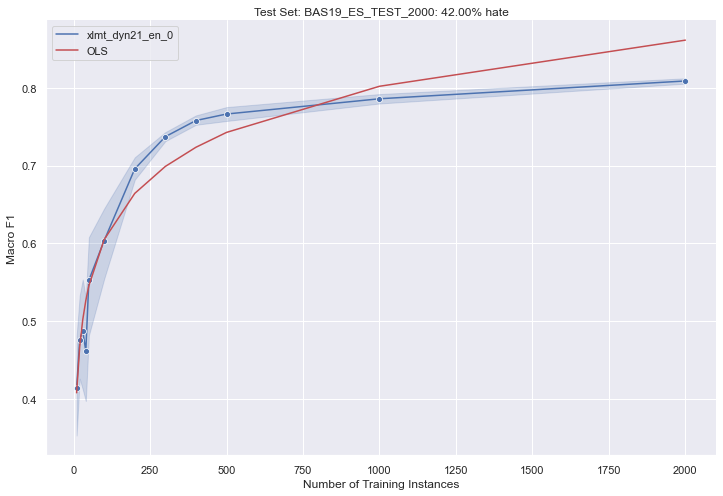


TESTSET: FOR19_PT_TEST_2000
MODEL:	 XLMT_DYN21_EN_0

                            OLS Regression Results                            
Dep. Variable:               macro_f1   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     474.4
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           3.70e-43
Time:                        14:45:55   Log-Likelihood:                 157.02
No. Observations:                 120   AIC:                            -310.0
Df Residuals:                     118   BIC:                            -304.5
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

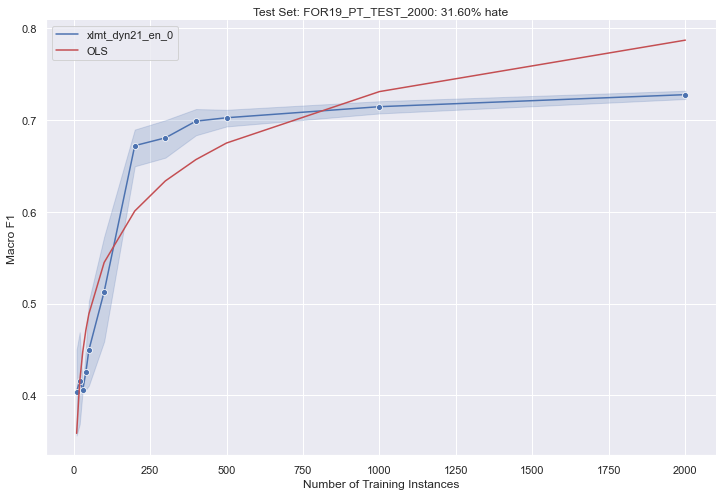


TESTSET: OUS19_AR_TEST_1000
MODEL:	 XLMT_DYN21_EN_0

                            OLS Regression Results                            
Dep. Variable:               macro_f1   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     620.5
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           8.14e-49
Time:                        14:45:55   Log-Likelihood:                 172.34
No. Observations:                 120   AIC:                            -340.7
Df Residuals:                     118   BIC:                            -335.1
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

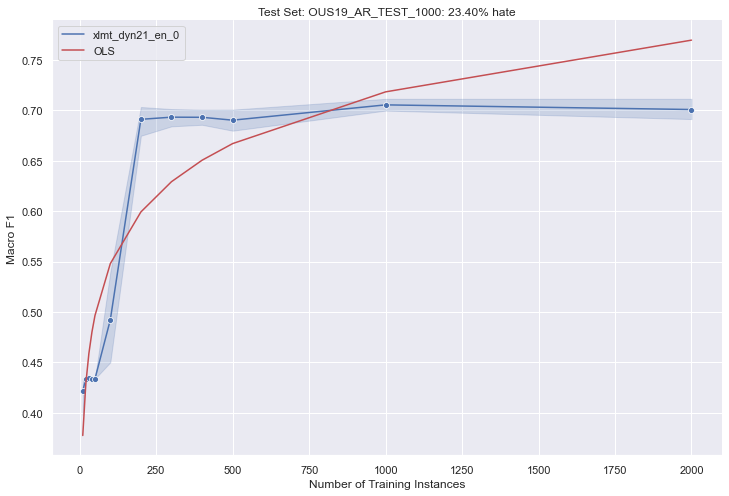


TESTSET: SAN20_IT_TEST_2000
MODEL:	 XLMT_DYN21_EN_0

                            OLS Regression Results                            
Dep. Variable:               macro_f1   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     240.6
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           2.92e-30
Time:                        14:45:55   Log-Likelihood:                 116.57
No. Observations:                 120   AIC:                            -229.1
Df Residuals:                     118   BIC:                            -223.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

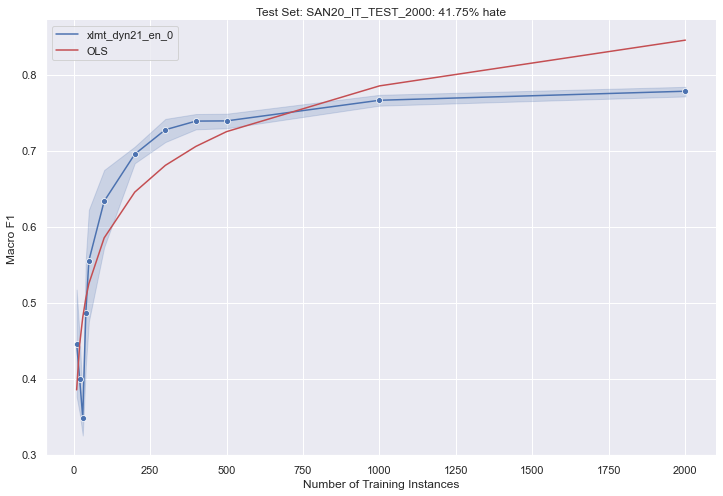

In [221]:
def fit_ols(metrics_df, testset, model):

    regression_df = metrics_df[metrics_df.selection_strat_category=="random"].copy()
    regression_df = regression_df[regression_df.testset==testset]
    regression_df = regression_df[regression_df.model==model]

    X = regression_df.log_train_size
    Y = regression_df.macro_f1

    model = sm.OLS(Y, sm.add_constant(X))
    results = model.fit(cov_type='HC3')

    print(results.summary(),"\n")
    
    print(round(results.params, 4))
    print("R2 (adj):\t",round(results.rsquared_adj*100,2))
    
    # create plot with OLS results and original data
    
    f = plt.figure(figsize=(12,8))
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = regression_df, estimator="mean", marker="o", ci=95)
    p.plot(regression_df.train_size, results.fittedvalues, "r-", label="OLS")
    #p.plot(regression_df.train_size, Y, ".", label="data")
    
    p.set_title(f"Test Set: {testset.upper()}: {results_dict[testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.legend(loc="best")
    sns.despine()
    plt.show()
    
    return None

for testset in ["bas19_es_test_2000", "for19_pt_test_2000", "ous19_ar_test_1000", "san20_it_test_2000"]:
                #"has19_hi_test_1318", "has20_hi_test_1269","has21_hi_test_2000"]:
#for testset in ["hatecheck_es", "hatecheck_pt", "hatecheck_ar", "hatecheck_it", "hatecheck_hi"]:
    for model in ["xlmt_dyn21_en_0"]:
        print("==="*20)
        print("TESTSET:",testset.upper())
        print("MODEL:\t",model.upper())
        print("==="*20,"\n")
        fit_ols(metrics_df, testset, model)
        print()